In [1]:
import jax
import os
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np
import pandas as pd
import seaborn as sns

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from genot.models.model import GENOT
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp
import moscot
from moscot.problems.cross_modality import TranslationProblem
from sklearn.linear_model import LinearRegression

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/py

In [2]:
adata_rna = moscot.datasets.bone_marrow(rna=True)
adata_atac = moscot.datasets.bone_marrow(rna=False)

## (tau_a =) 30 small/large unbalancedness 

In [3]:
def create_helper_col(x):
    if x["cell_type"] in ["Normoblast", "Erythroblast", "Proerythroblast"]:
        return x["cell_type"]
    return "other"
    
adata_atac.obs["helper"] = adata_atac.obs.apply(create_helper_col, axis=1)

In [4]:
import scipy 
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

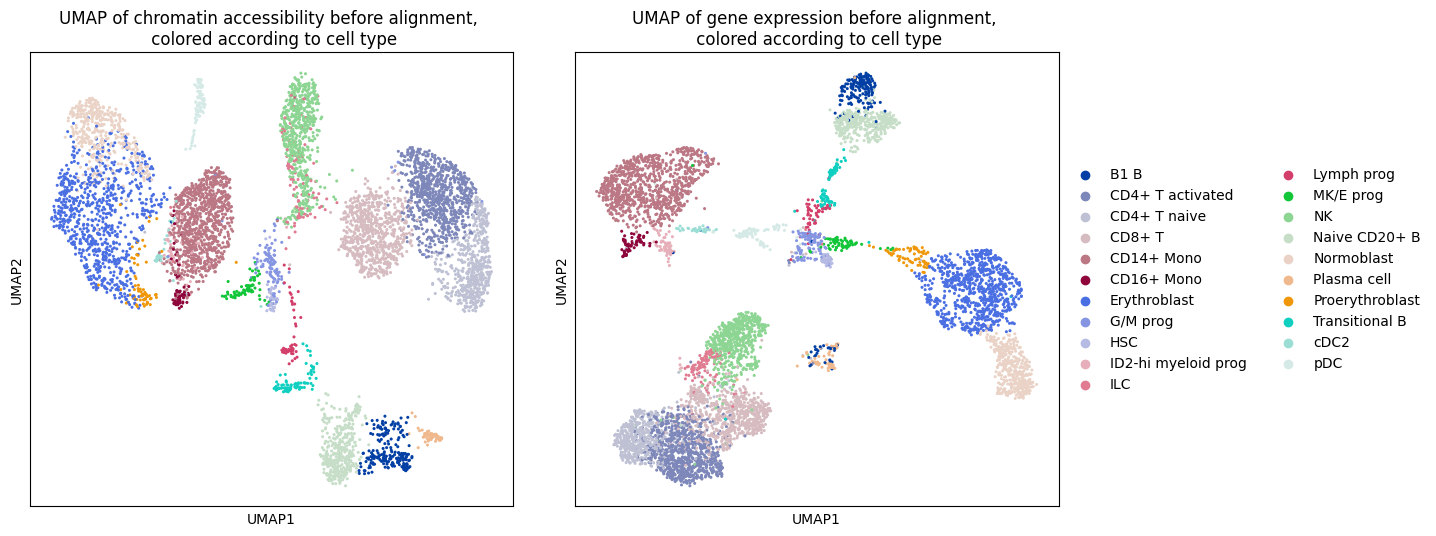

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
)

In [7]:
adata_rna_red = adata_rna[~adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_atac_red = adata_atac[~adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_atac_complement = adata_atac[adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()
adata_rna_complement = adata_rna[adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()

In [8]:
n_cells=len(adata_atac_red)

n_samples_train = int(n_cells * 0.6)
n_samples_test = n_cells - n_samples_train

inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_samples_train))) - set(inds_train))



m_cells=len(adata_atac_complement)

m_samples_train_complement = int(m_cells * 0.6)
m_samples_test_complement = m_cells - m_samples_train_complement

inds_train_complement = np.asarray(jax.random.choice(jax.random.PRNGKey(0), m_cells, (m_samples_train_complement,), replace=False))
inds_test_complement = list(set(list(range(m_samples_train_complement))) - set(inds_train_complement))


adata_source_train = adata_atac_red[inds_train,:]
adata_source_test = adata_atac_red[inds_test,:]

adata_target_train = adata_rna_red[inds_train,:]
adata_target_test = adata_rna_red[inds_test,:]

adata_source_train_complement = adata_atac_complement[inds_train_complement,:]
adata_source_test_complement = adata_atac_complement[inds_test_complement,:]

adata_source_train_final = sc.concat(
    [adata_source_train, adata_source_train_complement],
    join="outer",
)

adata_source_test_final = sc.concat(
    [adata_source_test, adata_source_test_complement],
    join="outer",
)

target_train = np.concatenate((adata_target_train.obsm["geneactivity_scvi"], adata_target_train.obsm["GEX_X_pca"]), axis=1)
source_train = np.concatenate((adata_source_train_final.obsm["geneactivity_scvi"], adata_source_train_final.obsm["ATAC_lsi_l2_norm"]), axis=1)
source_test_red = np.concatenate((adata_source_test.obsm["geneactivity_scvi"], adata_source_test.obsm["ATAC_lsi_l2_norm"]), axis=1)
source_test = np.concatenate((adata_source_test_final.obsm["geneactivity_scvi"], adata_source_test_final.obsm["ATAC_lsi_l2_norm"]), axis=1)
target_test = np.concatenate((adata_target_test.obsm["geneactivity_scvi"], adata_target_test.obsm["GEX_X_pca"]), axis=1)
source_train_red = np.concatenate((adata_source_train.obsm["geneactivity_scvi"], adata_source_train.obsm["ATAC_lsi_l2_norm"]), axis=1)

In [9]:
foscttms_train = []
foscttms_test = []

for seed in range(3):
    neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
    linear_ot_solver = sinkhorn.Sinkhorn(
                    momentum=acceleration.Momentum(value=1., start=25)
            )
    solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=5e-2, linear_ot_solver=linear_ot_solver)
    
    
    mlp_eta = MLP_marginal(256, 5)
    mlp_xi = MLP_marginal(256, 5)
    
    genot = GENOT(neural_net, 
                  epsilon=None,
                  mlp_eta=mlp_eta, 
                  mlp_xi=mlp_xi,
                  tau_a=0.30, 
                  tau_b=1.0, 
                  scale_cost="mean", 
                  input_dim=source_train.shape[1],
                  output_dim=target_train.shape[1], 
                  iterations=10_000, 
                  ot_solver=solver,
                  k_noise_per_x=1, 
                  fused_penalty = 0.43,
                  split_dim=adata_target_train.obsm["geneactivity_scvi"].shape[1], 
                  seed=seed)
    genot(source_train, target_train, 1024, 1024)
    res = [None] * 30

    for i in range(30):
        res[i] = genot.transport(source_test_red, seed=i)[0][0,...]
    
    gex_predicted = jnp.mean(np.asarray(res), axis=0)
    foscttms_train.append(foscttm(gex_predicted, target_test))


    res = [None] * 30

    for i in range(30):
        res[i] = genot.transport(source_train_red, seed=i)[0][0,...]
    
    gex_predicted = jnp.mean(np.asarray(res), axis=0)
    foscttms_test.append(foscttm(gex_predicted, target_train))


    
    adata_source_test_final.obs[f"reweighting_{seed}"] = genot.state_eta.apply_fn({"params": genot.state_eta.params}, x=source_test)
    adata_source_train_final.obs[f"reweighting_{seed}"] = genot.state_eta.apply_fn({"params": genot.state_eta.params}, x=source_train)

I0000 00:00:1732124430.456261 3475542 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6750 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:4c:00.0, compute capability: 7.0
100%|██████████| 10000/10000 [03:07<00:00, 53.37it/s]


In [10]:
foscttms_test, foscttms_train

([0.1707, 0.1613, 0.1557], [0.1655, 0.1566, 0.1515])

In [11]:
df_result_test = adata_source_test_final.obs[["helper", *[f"reweighting_{seed}" for seed in range(3)]]]
df_result_train = adata_source_train_final.obs[["helper", *[f"reweighting_{seed}" for seed in range(3)]]]

In [12]:
df_result_train["cell_type"] = adata_source_train_final.obs["cell_type"]
df_result_test["cell_type"] = adata_source_test_final.obs["cell_type"]

/tmp/ipykernel_3475542/1579974173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_train["cell_type"] = adata_source_train_final.obs["cell_type"]
/tmp/ipykernel_3475542/1579974173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_test["cell_type"] = adata_source_test_final.obs["cell_type"]


### moscot

In [13]:
ftp = TranslationProblem(adata_src=adata_source_train_final, adata_tgt=adata_target_train)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca", joint_attr="geneactivity_scvi"
)
ftp = ftp.solve(epsilon=0.5e-2, alpha=0.7, tau_a=0.3, tau_b=1.0, max_iterations=10_000)

target_features_predicted = ftp["src", "tgt"].pull(target_train, scale_by_marginals=True, normalize=False)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3734, 2985)].                                          


In [14]:
def lr_predictor(source_train: jnp.ndarray, source_test: jnp.ndarray, target_features_predicted: jnp.ndarray, positive_weights: bool = False) -> jnp.ndarray:
    X_train=np.transpose(source_train)
    y_train=np.transpose(source_test)

    lr = LinearRegression(fit_intercept=False, positive=positive_weights)
    sol = lr.fit(X_train, y_train)
    return np.apply_along_axis(lambda x: np.average(target_features_predicted, axis=0, weights=x), axis=1, arr=sol.coef_)

In [15]:
adata_source_test_final.obs["left_reweighting"] = lr_predictor(source_train, source_test, ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a), positive_weights=True)

In [16]:
adata_source_train_final.obs["left_reweighting"] = ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a)

In [17]:
df_test_result_moscot = adata_source_test_final.obs[["helper", "left_reweighting"]]
df_train_result_moscot = adata_source_train_final.obs[["helper", "left_reweighting"]]

In [18]:
df_test_result_moscot["cell_type"] = adata_source_test_final.obs["cell_type"]

/tmp/ipykernel_3475542/555272804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result_moscot["cell_type"] = adata_source_test_final.obs["cell_type"]


### Plots

In [19]:
df_genot = df_result_test.copy()
df_genot["model"] = "UGENOT-FGW"
df_genot["left_reweighting"] = df_genot["reweighting_0"]
df_discrete = df_test_result_moscot.copy()
df_discrete["model"] = "discrete UFGW"

In [20]:
df = df_genot.merge(df_discrete, how="outer")

In [21]:
df["cell_type"] = df["cell_type"].astype("category") 

In [22]:
rest = list(set(df["cell_type"].cat.categories) - set(["Normoblast", "Erythroblast", "Proerythroblast", "MK/E prog", "HSC"]))

df["cell_type_ordered"] = pd.Categorical(df.cell_type, categories=["Normoblast", "Erythroblast", "Proerythroblast", "MK/E prog", "HSC"] + rest, ordered=True)

/tmp/ipykernel_3475542/3095600217.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Learnt growth rates per cell type for $\\tau_1=0.3$')

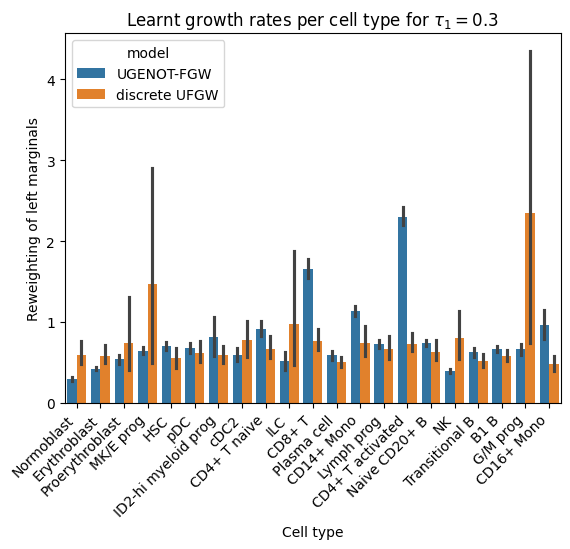

In [23]:
g = sns.barplot(df, x="cell_type_ordered", y="left_reweighting", hue="model")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_ylabel("Reweighting of left marginals")
g.set_xlabel("Cell type")
g.set_title(r"Learnt growth rates per cell type for $\tau_1=0.3$")

## 80

In [24]:
foscttms_train = []
foscttms_test = []

for seed in range(3):
    neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
    linear_ot_solver = sinkhorn.Sinkhorn(
                    momentum=acceleration.Momentum(value=1., start=25)
            )
    solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=5e-2, linear_ot_solver=linear_ot_solver)
    
    
    mlp_eta = MLP_marginal(256, 5)
    mlp_xi = MLP_marginal(256, 5)
    
    genot = GENOT(neural_net, 
                  epsilon=None, 
                  mlp_eta=mlp_eta,
                  mlp_xi=mlp_xi, 
                  tau_a=0.80, 
                  tau_b=1.0, 
                  scale_cost="mean",
                  input_dim=source_train.shape[1],
                  output_dim=target_train.shape[1], 
                  iterations=10_000, 
                  ot_solver=solver,
                  k_noise_per_x=1, 
                  fused_penalty = 0.43, 
                  split_dim=adata_target_train.obsm["geneactivity_scvi"].shape[1], 
                  seed=seed)
    genot(source_train, target_train, 1024, 1024)
    res = [None] * 30

    for i in range(30):
        res[i] = genot.transport(source_test_red, seed=i)[0][0,...]
    
    gex_predicted = jnp.mean(np.asarray(res), axis=0)
    foscttms_train.append(foscttm(gex_predicted, target_test))
    res = [None] * 30

    for i in range(30):
        res[i] = genot.transport(source_train_red, seed=i)[0][0,...]
    
    gex_predicted = jnp.mean(np.asarray(res), axis=0)
    foscttms_test.append(foscttm(gex_predicted, target_train))


    
    adata_source_test_final.obs[f"reweighting_{seed}"] = genot.state_eta.apply_fn({"params": genot.state_eta.params}, x=source_test)
    adata_source_train_final.obs[f"reweighting_{seed}"] = genot.state_eta.apply_fn({"params": genot.state_eta.params}, x=source_train)

100%|██████████| 10000/10000 [04:29<00:00, 37.16it/s]


In [25]:
foscttms_test, foscttms_train

([0.1341, 0.125, 0.135], [0.1319, 0.123, 0.1321])

In [26]:
df_result_test = adata_source_test_final.obs[["helper", *[f"reweighting_{seed}" for seed in range(3)]]]
df_result_train = adata_source_train_final.obs[["helper", *[f"reweighting_{seed}" for seed in range(3)]]]

In [27]:
df_result_test["cell_type"] = adata_source_test_final.obs["cell_type"]

/tmp/ipykernel_3475542/1710889945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_test["cell_type"] = adata_source_test_final.obs["cell_type"]


### moscot

In [28]:
ftp = TranslationProblem(adata_src=adata_source_train_final, adata_tgt=adata_target_train)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca", joint_attr="geneactivity_scvi"
)
ftp = ftp.solve(epsilon=0.5e-2, alpha=0.7, tau_a=0.80, tau_b=1.0, max_iterations=10_000)

target_features_predicted = ftp["src", "tgt"].pull(target_train, scale_by_marginals=True, normalize=False)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3734, 2985)].                                          


In [29]:
adata_source_test_final.obs["left_reweighting"] = lr_predictor(source_train, source_test, ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a), positive_weights=True)

In [30]:
adata_source_train_final.obs["left_reweighting"] = ftp["src", "tgt"].solution.a*len(ftp["src", "tgt"].solution.a)

In [31]:
df_test_result_moscot = adata_source_test_final.obs[["helper", "left_reweighting"]]
df_train_result_moscot = adata_source_train_final.obs[["helper", "left_reweighting"]]

In [32]:
df_test_result_moscot["cell_type"] = adata_source_test_final.obs["cell_type"]

/tmp/ipykernel_3475542/555272804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result_moscot["cell_type"] = adata_source_test_final.obs["cell_type"]


### Plot

In [33]:
df_genot = df_result_test.copy()
df_genot["model"] = "UGENOT-FGW"
df_genot["left_reweighting"] = df_genot["reweighting_0"]
df_discrete = df_test_result_moscot.copy()
df_discrete["model"] = "discrete UFGW"

In [34]:
df = df_genot.merge(df_discrete, how="outer")

In [35]:
df["cell_type"] = df["cell_type"].astype("category") 

In [36]:
rest = list(set(df["cell_type"].cat.categories) - set(["Normoblast", "Erythroblast", "Proerythroblast", "MK/E prog", "HSC"]))

df["cell_type_ordered"] = pd.Categorical(df.cell_type, categories=["Normoblast", "Erythroblast", "Proerythroblast", "MK/E prog", "HSC"] + rest, ordered=True)

/tmp/ipykernel_3475542/690889472.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


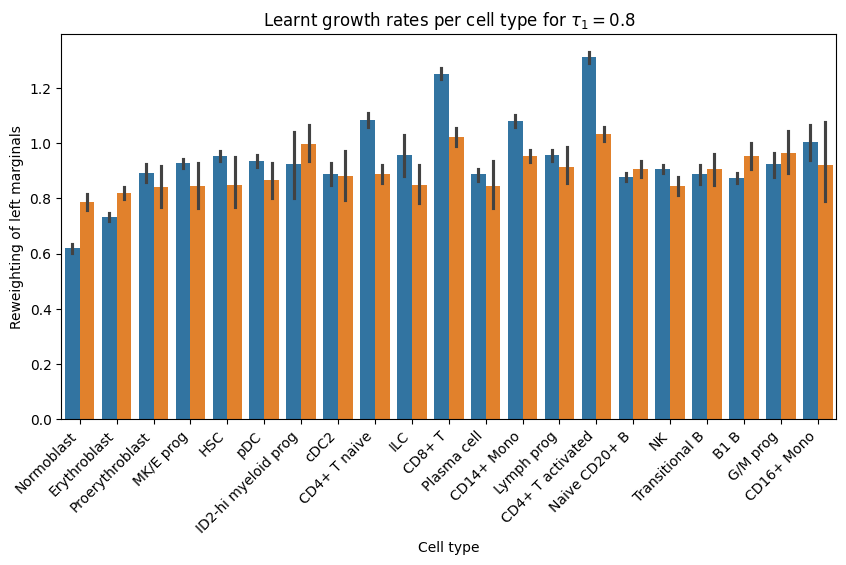

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

g = sns.barplot(df, x="cell_type_ordered", y="left_reweighting", hue="model", ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_ylabel("Reweighting of left marginals")
g.set_xlabel("Cell type")
g.set_title(r"Learnt growth rates per cell type for $\tau_1=0.8$")
g.get_legend().remove()

In [38]:
df

,helper,reweighting_0,reweighting_1,reweighting_2,cell_type,model,left_reweighting,cell_type_ordered
0,Erythroblast,0.380979,0.364363,0.377041,Erythroblast,UGENOT-FGW,0.380979,Erythroblast
1,Erythroblast,0.385975,0.389668,0.376161,Erythroblast,UGENOT-FGW,0.385975,Erythroblast
2,Erythroblast,0.404889,0.376416,0.374802,Erythroblast,UGENOT-FGW,0.404889,Erythroblast
3,Erythroblast,0.467435,0.504841,0.482298,Erythroblast,UGENOT-FGW,0.467435,Erythroblast
4,Erythroblast,0.474800,0.476436,0.444234,Erythroblast,UGENOT-FGW,0.474800,Erythroblast
...,...,...,...,...,...,...,...,...
2977,other,NaN,NaN,NaN,pDC,discrete UFGW,0.995745,pDC
2978,other,NaN,NaN,NaN,pDC,discrete UFGW,1.026843,pDC
2979,other,NaN,NaN,NaN,pDC,discrete UFGW,1.060313,pDC
2980,other,NaN,NaN,NaN,pDC,discrete UFGW,1.062303,pDC
